In [ ]:
# for Colab
!pip install botorch

In [1]:
import torch
import botorch
import gpytorch

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt

from predict_EI_simple import calculate_EI_GP, GaussainProcessRandomDataset
from utils import get_uniform_randint_generator, get_param_value


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [2]:
def plot_gp_posterior(ax, posterior, test_x, train_x, train_y, color, name=None):
    lower, upper = posterior.mvn.confidence_region()
    mean = posterior.mean.squeeze().cpu().numpy()
    lower = lower.squeeze().cpu().numpy()
    upper = upper.squeeze().cpu().numpy()

    train_x = train_x.squeeze().cpu().numpy()
    train_y = train_y.squeeze().cpu().numpy()
    test_x = test_x.squeeze().cpu().numpy()

    extension = '' if name is None else f' {name}'

    # Plot training points as black stars
    ax.plot(train_x, train_y, f'{color}*', label=f'Observed Data{extension}')
    # Plot posterior means as blue line
    ax.plot(test_x, mean, color, label=f'Mean{extension}')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower, upper, color=color, alpha=0.5, label=f'Confidence{extension}')


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


True:   l=0.211, sigma^2=23.9, noise=1e-06
Fitted: l=0.137, sigma^2=11.9, noise=0


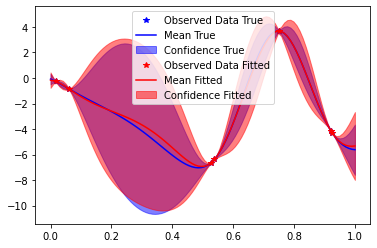

In [96]:
# randint_gen = get_uniform_randint_generator(4, 20)
# dataset = GaussainProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=randint_gen, observation_noise=False,
#     device=device)

# torch.manual_seed(1703)

OBSERVATION_NOISE = False

dataset = GaussainProcessRandomDataset(
    dimension=1, n_datapoints=7, observation_noise=OBSERVATION_NOISE,
    device=device)

x_values, y_values, random_model, model = next(dataset)


true_lengthscale = random_model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
true_outputscale = random_model.covar_module.outputscale.squeeze().detach().numpy()
true_noise = random_model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()


test_x = torch.linspace(0, 1, 100, device=device)

# Get posterior under true model parameters
posterior_true = random_model.posterior(test_x, observation_noise=OBSERVATION_NOISE)


OPTIMIZE_RANDOM_MODEL = False # Should always be False, because random_model is broken
INIT_MODEL_PARAMS_TO_RANDOM_PARAMS = False

# Get posterior by fitting by MAP
if OPTIMIZE_RANDOM_MODEL:
    mll = ExactMarginalLogLikelihood(random_model.likelihood, random_model)
    fit_gpytorch_mll(mll)
    posterior_fitted = random_model.posterior(test_x, observation_noise=OBSERVATION_NOISE)

    fitted_model = random_model
else:
    # Set model's parameters to those of random_model
    if INIT_MODEL_PARAMS_TO_RANDOM_PARAMS:
        random_model_params_dict = {name: get_param_value(random_model, name)
                                    for name, param in model.named_parameters()}
        model.initialize(**random_model_params_dict)
    
    # set train data of model to that of random_model
    model.set_train_data(
        x_values, y_values.squeeze(-1), strict=False)
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    posterior_fitted = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)

    fitted_model = model

fitted_lengthscale = fitted_model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
fitted_outputscale = fitted_model.covar_module.outputscale.squeeze().detach().numpy()
fitted_noise = fitted_model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()


with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    description_true   = f'True:   l={  true_lengthscale:.3g}, sigma^2={  true_outputscale:.3g}, noise={true_noise:.3g}'
    description_fitted = f'Fitted: l={fitted_lengthscale:.3g}, sigma^2={fitted_outputscale:.3g}, noise={fitted_noise:.3g}'
    print(description_true)
    print(description_fitted)
    
    plot_gp_posterior(ax, posterior_true, test_x, x_values, y_values, 'b', name='True')
    plot_gp_posterior(ax, posterior_fitted, test_x, x_values, y_values, 'r', name='Fitted')

    ax.legend()

In [32]:
{k:v for k, v in model.named_parameters()}

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([1.0000e-06], requires_grad=True),
 'mean_module.raw_constant': Parameter containing:
 tensor(0., requires_grad=True),
 'covar_module.raw_outputscale': Parameter containing:
 tensor(0., requires_grad=True),
 'covar_module.base_kernel.raw_lengthscale': Parameter containing:
 tensor([[0.]], requires_grad=True)}

In [31]:
{
    name: get_param_value(random_model, name)
    for name, param in model.named_parameters()
}

{'likelihood.noise_covar.raw_noise': Parameter containing:
 tensor([0.], requires_grad=True),
 'mean_module.raw_constant': Parameter containing:
 tensor(0.5313, requires_grad=True),
 'covar_module.raw_outputscale': tensor(14.9892),
 'covar_module.base_kernel.raw_lengthscale': tensor([[0.9345]])}